## Input Catalog and Scene Information

Specify the TIC Id you desire to get TIC information and MAST data information.  Then hit run all. I recommend showing as a dashboard.

In [8]:
star_name="hat-p-11"  #string TIC ID or string of full star name
size=.11 #Cone Search size in degrees
maglimit = 15  #Dimmest stars you want retrieved
nearest=15  #Limit number of stars shown
#Column names
cols=['ID', 'Tmag', 'Jmag', 'Teff','logg','ra', 'dec','dstArcSec']

----

In [9]:
import tess_mast_query as tq

### TESS Input Catalog Cone Search

In [10]:
ticinfo = tq.get_tic_info(star_name, radius_deg = size, cols=cols)
ticinfo.show_in_notebook(display_length=nearest)

idx,ID,Tmag,Jmag,Teff,logg,ra,dec,dstArcSec
0,28230919,8.5077,7.608,4777.56,4.5631,297.709364402628,48.0808603792123,3.607815935575038e-06
1,1881918636,18.9336,nan,nan,nan,297.707142702312,48.0829554811124,9.243266115111794
2,28230924,14.4609,13.592,5826.0,3.96658,297.710424618818,48.0838792939985,11.163206704403697
3,28230906,12.1639,10.921,4349.0,nan,297.689816529734,48.0747453945307,51.915636360590405
4,28230962,14.25,14.063,nan,nan,297.7143,48.098537,64.73315676933986
5,28230896,14.1279,13.421,5671.0,4.47469,297.690769621972,48.0671587407976,66.58564566539737
6,28230875,13.373,12.26,nan,nan,297.725154,48.059692,85.14755964034359
7,10000766665,12.607,10.959,nan,nan,297.725006,48.059597,85.29614379064938
8,28230947,11.649,10.981,5686.48,4.07388,297.742187229689,48.0934604425919,91.03763902043121
9,28230880,13.4529,12.797,6174.2,4.24033,297.668759810979,48.0613993664351,120.20400763962387


### TESS Image near the Selected Star

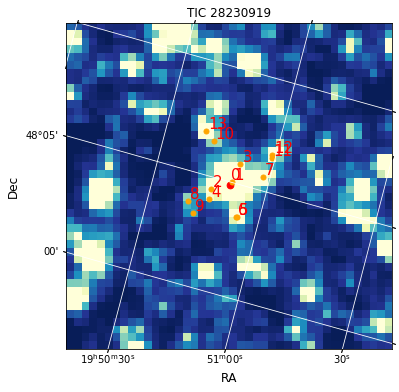

In [11]:
image, wcs = tq.overplot_ticffi(ticinfo, cutout_deg = size, nearest=nearest)

## Lightcurve data at MAST

In [12]:
ticlist = ticinfo['ID']
obs_table, dv_table = tq.get_twomin_obs(ticlist[0:3])
obs_table.show_in_notebook()

idx,target_tic,sectors,GI_nums,obs_id,Exp_time_min,t_min,t_max
0,28230919,14,G022062_G022200_G022053,tess2019198215352-s0014-0000000028230919-0150-s,2,58682.84687433,58709.70380731
1,28230919,15,G022062_G022200_G022053,tess2019226182529-s0015-0000000028230919-0151-s,2,58710.85797325,58736.9093508


### TESS Planet Search Results Available at MAST

In [13]:
dv_table.show_in_notebook()

idx,target_tic,sector_range,obs_id,Exp_time_min,t_min,t_max
0,28230919,s0014-s0016,tess2019199201929-s0014-s0016-0000000028230919-00253,2,58682.84897424,58736.91142463


NameError: name 'ticid' is not defined